## Load Data & Modify


In [1]:
import kagglehub

DATA_BASE_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
IMAGES_PATH = DATA_BASE_PATH + "/images/Images"

print("Path to dataset files:", IMAGES_PATH)

c:\Users\itay8\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\itay8\.cache\kagglehub\datasets\jessicali9530\stanford-dogs-dataset\versions\2/images/Images


In [2]:

import os
import shutil

#delete all classes but selected
def delete_classes(images_path, keep_classes):
    for root, dirs, files in os.walk(images_path):
        class_name = os.path.basename(root)
        if class_name not in keep_classes and root != images_path :
            try:
                shutil.rmtree(root)
                print(f"Deleted class: {class_name}")
            except OSError as e:
                print(f"Error deleting class {class_name}: {e}")

classes_to_keep = ["n02085936-Maltese_dog", "n02112018-Pomeranian", "n02111889-Samoyed",
                    "n02086240-Shih-Tzu", "n02110958-pug", "n02099601-golden_retriever",
                    "n02110185-Siberian_husky", "n02094433-Yorkshire_terrier",
                    "n02085620-Chihuahua", "n02106550-Rottweiler", "n02107142-Doberman",
                    "n02093428-American_Staffordshire_terrier", "n02086079-Pekinese",
                    "n02088364-beagle", "n02097047-miniature_schnauzer",
                    "n02099712-Labrador_retriever", "n02106030-collie",
                    "n02107312-miniature_pinscher", "n02113186-Cardigan",
                    "n02113624-toy_poodle", "n02106662-German_shepherd", "n02091134-whippet"]

delete_classes(IMAGES_PATH, classes_to_keep)

In [3]:
#print how many classes
import os

def count_classes(images_path):
    class_count = 0
    for root, _, _ in os.walk(images_path):
        if root != images_path:  # Exclude the root directory itself
            class_count +=1
            #print(root)
    return class_count

print(f"Number of classes: {count_classes(IMAGES_PATH)}")

Number of classes: 22


## Train on 224x224 Resnet18


In [4]:
import os
import random
import matplotlib.pyplot as plt
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)

True
12.6
2.6.0+cu126


In [5]:

# Define paths and parameters
BATCH_SIZE = 32  
NUM_EPOCHS = 20 

# Data transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 for ResNet18
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(IMAGES_PATH, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}")

#Save the model
PATH = r"C:\Users\itay8\Desktop\ai\dogrecog\server\model\model.pth"
torch.save(model.state_dict(), PATH)

#Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Overall accuracy: {accuracy:.2f}%")



c:\Users\itay8\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\itay8\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 1.2912
Epoch 2/20, Loss: 0.2823
Epoch 3/20, Loss: 0.0855
Epoch 4/20, Loss: 0.0343
Epoch 5/20, Loss: 0.0195
Epoch 6/20, Loss: 0.0136
Epoch 7/20, Loss: 0.0097
Epoch 8/20, Loss: 0.0081
Epoch 9/20, Loss: 0.0065
Epoch 10/20, Loss: 0.0051
Epoch 11/20, Loss: 0.0042
Epoch 12/20, Loss: 0.0033
Epoch 13/20, Loss: 0.0034
Epoch 14/20, Loss: 0.0026
Epoch 15/20, Loss: 0.0027
Epoch 16/20, Loss: 0.0022
Epoch 17/20, Loss: 0.0019
Epoch 18/20, Loss: 0.0017
Epoch 19/20, Loss: 0.0015
Epoch 20/20, Loss: 0.0012
Overall accuracy: 90.85%


In [6]:
from torchsummary import summary
summary(model, input_size = (3, 224, 224), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [13]:
from graphviz import Digraph

dot = Digraph(format="png", comment="Color-Coded ResNet-18")

# Input and Initial Layers
dot.node("Input", "Input", style="filled", fillcolor="#D6EAF8")  # light blue
dot.node("Conv1", "Conv7x7 + BN + ReLU", style="filled", fillcolor="#AED6F1")  # blue
dot.node("MaxPool", "MaxPool3x3", style="filled", fillcolor="#D5DBDB")  # gray
dot.edge("Input", "Conv1")
dot.edge("Conv1", "MaxPool")

# Function to add a BasicBlock cluster
def add_basicblock(dot, block_name, parent):
    with dot.subgraph(name=f"cluster_{block_name}") as c:
        c.attr(label=block_name, style="dashed")

        c.node(f"{block_name}_x", "Input x", style="filled", fillcolor="#D6EAF8")  # input
        c.node(f"{block_name}_conv1", "Conv3x3 + BN + ReLU", style="filled", fillcolor="#AED6F1")  # conv
        c.node(f"{block_name}_conv2", "Conv3x3 + BN", style="filled", fillcolor="#AED6F1")  # conv
        c.node(f"{block_name}_add", "Add (x + F(x))", style="filled", fillcolor="#F9E79F")  # add
        c.node(f"{block_name}_relu", "ReLU", style="filled", fillcolor="#A9DFBF")  # relu

        c.edge(f"{block_name}_x", f"{block_name}_conv1")
        c.edge(f"{block_name}_conv1", f"{block_name}_conv2")
        c.edge(f"{block_name}_conv2", f"{block_name}_add")
        c.edge(f"{block_name}_add", f"{block_name}_relu")

        # Residual connection
        c.edge(f"{block_name}_x", f"{block_name}_add", label="skip", style="dashed", color="gray")

    dot.edge(parent, f"{block_name}_x")

# Add residual layers
prev = "MaxPool"
for i in range(1, 5):
    layer_name = f"Layer{i}"
    add_basicblock(dot, layer_name, prev)
    prev = f"{layer_name}_relu"

# Final layers
dot.node("AvgPool", "AdaptiveAvgPool", style="filled", fillcolor="#D5DBDB")  # gray
dot.node("FC", "Fully Connected Layer", style="filled", fillcolor="#BB8FCE")  # purple
dot.node("Output", "Output", style="filled", fillcolor="#D6EAF8")  # light blue

dot.edge(prev, "AvgPool")
dot.edge("AvgPool", "FC")
dot.edge("FC", "Output")

# Render
dot.render("resnet18_color_coded", cleanup=True)


'resnet18_color_coded.png'

## Analyze

100%|██████████| 750M/750M [00:31<00:00, 25.3MB/s] 

Extracting files...


Training with all classes...
Using all classes, no deletion performed.
Number of classes in dataset: 120
Number of samples in dataset: 20580
Epoch 1/5, Loss: 2.2853
Epoch 2/5, Loss: 0.8516
Epoch 3/5, Loss: 0.3718
Epoch 4/5, Loss: 0.1477
Epoch 5/5, Loss: 0.0664
Training with selected classes...
Deleted class: n02085782-Japanese_spaniel
Deleted class: n02086646-Blenheim_spaniel
Deleted class: n02086910-papillon
Deleted class: n02087046-toy_terrier
Deleted class: n02087394-Rhodesian_ridgeback
Deleted class: n02088094-Afghan_hound
Deleted class: n02088238-basset
Deleted class: n02088466-bloodhound
Deleted class: n02088632-bluetick
Deleted class: n02089078-black-and-tan_coonhound
Deleted class: n02089867-Walker_hound
Deleted class: n02089973-English_foxhound
Deleted class: n02090379-redbone
Deleted class: n02090622-borzoi
Deleted class: n02090721-Irish_wolfhound
Deleted class: n02091032-Italian_greyhound
Deleted class: n02091244-Ibizan_hound
Deleted class: n02091467-Norwegian_elkhound
Delet

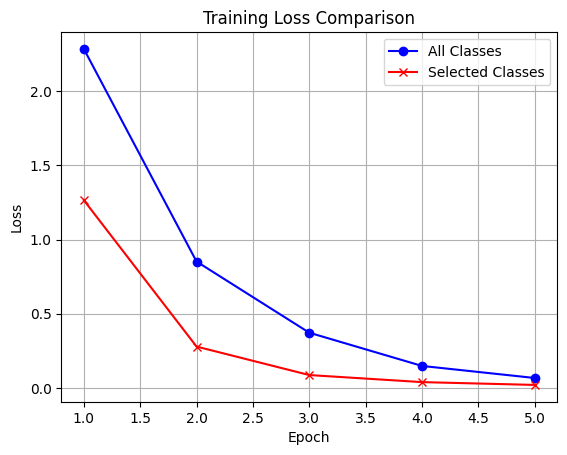

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import kagglehub
import shutil
import numpy as np

# Function to delete the existing dataset if it exists
def delete_existing_dataset(dataset_path):
    if os.path.exists(dataset_path):
        try:
            shutil.rmtree(dataset_path)
            print(f"Deleted existing dataset at: {dataset_path}")
        except OSError as e:
            print(f"Error deleting dataset at {dataset_path}: {e}")

# Define dataset base path
DATA_BASE_PATH = "./stanford-dogs-dataset"  # You can define your custom path if needed
IMAGES_PATH = DATA_BASE_PATH + "/images/Images"

# First, delete any existing dataset before downloading
delete_existing_dataset(IMAGES_PATH)

# Now, download the dataset
DATA_BASE_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
IMAGES_PATH = DATA_BASE_PATH + "/images/Images"

# Define classes to keep
classes_to_keep = ["n02085936-Maltese_dog", "n02112018-Pomeranian", "n02111889-Samoyed",
                   "n02086240-Shih-Tzu", "n02110958-pug", "n02099601-golden_retriever",
                   "n02110185-Siberian_husky", "n02094433-Yorkshire_terrier",
                   "n02085620-Chihuahua", "n02106550-Rottweiler", "n02107142-Doberman",
                   "n02093428-American_Staffordshire_terrier", "n02086079-Pekinese",
                   "n02088364-beagle", "n02097047-miniature_schnauzer",
                   "n02099712-Labrador_retriever", "n02106030-collie",
                   "n02107312-miniature_pinscher", "n02113186-Cardigan",
                   "n02113624-toy_poodle", "n02106662-German_shepherd",
                   "Shiba-Inu", "n02091134-whippet"]

# Function to delete all classes except the selected ones
def delete_classes(images_path, keep_classes):
    class_dirs = [os.path.join(images_path, class_name) for class_name in os.listdir(images_path)]
    deleted = False
    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)
        if os.path.isdir(class_dir) and class_name not in keep_classes:
            try:
                shutil.rmtree(class_dir)
                deleted = True
                print(f"Deleted class: {class_name}")
            except OSError as e:
                print(f"Error deleting class {class_name}: {e}")
    return deleted

# Prepare the datasets
def prepare_data(keep_classes=None):
    if keep_classes:
        # Filter classes
        deleted = delete_classes(IMAGES_PATH, keep_classes)
        if not deleted:
            print("No classes were deleted. Check the directory structure.")
    else:
        print("Using all classes, no deletion performed.")

    # Data transformations
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize images to 224x224 for ResNet18
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the dataset
    dataset = ImageFolder(IMAGES_PATH, transform=transform)
    print(f"Number of classes in dataset: {len(dataset.classes)}")
    print(f"Number of samples in dataset: {len(dataset)}")
    
    train_size = int(0.8 * len(dataset))  # 80% for training
    test_size = len(dataset) - train_size  # 20% for testing
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader, len(dataset.classes)

# Function to train and return the loss for each epoch
def train_model(train_loader, num_epochs, model, criterion, optimizer, device):
    epoch_losses = []
    
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    return epoch_losses

# Function to set up and run the training with a model
def run_training(keep_classes=None):
    # Prepare data loaders
    train_loader, test_loader, num_classes = prepare_data(keep_classes)

    # Load pre-trained ResNet18 model
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)  # Update final layer based on the number of classes

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Train the model and return losses
    return train_model(train_loader, num_epochs=5, model=model, criterion=criterion, optimizer=optimizer, device=device)

# Run training with all classes (no filtering)
print("Training with all classes...")
all_classes_losses = run_training(keep_classes=None)

# Run training with selected classes only (filtering)
print("Training with selected classes...")
selected_classes_losses = run_training(keep_classes=classes_to_keep)

# Plotting the loss comparison
plt.plot(np.arange(1, 6), all_classes_losses, label='All Classes', color='blue', marker='o')
plt.plot(np.arange(1, 6), selected_classes_losses, label='Selected Classes', color='red', marker='x')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 750M/750M [00:26<00:00, 29.3MB/s] 

Extracting files...


Training with all classes...
Using all classes, no deletion performed.
Number of classes in dataset: 120
Number of samples in dataset: 20580


c:\Users\itay8\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\itay8\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Test Accuracy: 0.6992
Epoch 2/5, Test Accuracy: 0.7432
Epoch 3/5, Test Accuracy: 0.7493
Epoch 4/5, Test Accuracy: 0.7612
Epoch 5/5, Test Accuracy: 0.7573
Training with selected classes...
Deleted class: n02085782-Japanese_spaniel
Deleted class: n02086646-Blenheim_spaniel
Deleted class: n02086910-papillon
Deleted class: n02087046-toy_terrier
Deleted class: n02087394-Rhodesian_ridgeback
Deleted class: n02088094-Afghan_hound
Deleted class: n02088238-basset
Deleted class: n02088466-bloodhound
Deleted class: n02088632-bluetick
Deleted class: n02089078-black-and-tan_coonhound
Deleted class: n02089867-Walker_hound
Deleted class: n02089973-English_foxhound
Deleted class: n02090379-redbone
Deleted class: n02090622-borzoi
Deleted class: n02090721-Irish_wolfhound
Deleted class: n02091032-Italian_greyhound
Deleted class: n02091244-Ibizan_hound
Deleted class: n02091467-Norwegian_elkhound
Deleted class: n02091635-otterhound
Deleted class: n02091831-Saluki
Deleted class: n02092002-Scottish

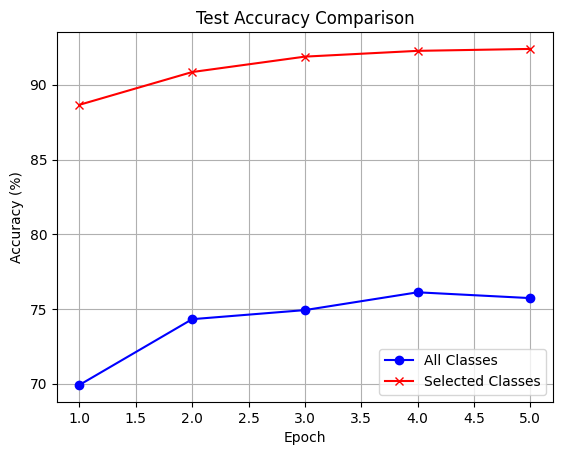

: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import kagglehub
import shutil
import numpy as np

# Function to delete the existing dataset if it exists
def delete_existing_dataset(dataset_path):
    if os.path.exists(dataset_path):
        try:
            shutil.rmtree(dataset_path)
            print(f"Deleted existing dataset at: {dataset_path}")
        except OSError as e:
            print(f"Error deleting dataset at {dataset_path}: {e}")

# Define dataset base path
DATA_BASE_PATH = "./stanford-dogs-dataset"
IMAGES_PATH = DATA_BASE_PATH + "/images/Images"

# First, delete any existing dataset before downloading
delete_existing_dataset(IMAGES_PATH)

# Now, download the dataset
DATA_BASE_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
IMAGES_PATH = DATA_BASE_PATH + "/images/Images"

# Define classes to keep
classes_to_keep = [
    "n02085936-Maltese_dog", "n02112018-Pomeranian", "n02111889-Samoyed",
    "n02086240-Shih-Tzu", "n02110958-pug", "n02099601-golden_retriever",
    "n02110185-Siberian_husky", "n02094433-Yorkshire_terrier",
    "n02085620-Chihuahua", "n02106550-Rottweiler", "n02107142-Doberman",
    "n02093428-American_Staffordshire_terrier", "n02086079-Pekinese",
    "n02088364-beagle", "n02097047-miniature_schnauzer",
    "n02099712-Labrador_retriever", "n02106030-collie",
    "n02107312-miniature_pinscher", "n02113186-Cardigan",
    "n02113624-toy_poodle", "n02106662-German_shepherd",
    "Shiba-Inu", "n02091134-whippet"
]

# Function to delete all classes except the selected ones
def delete_classes(images_path, keep_classes):
    class_dirs = [os.path.join(images_path, class_name) for class_name in os.listdir(images_path)]
    deleted = False
    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)
        if os.path.isdir(class_dir) and class_name not in keep_classes:
            try:
                shutil.rmtree(class_dir)
                deleted = True
                print(f"Deleted class: {class_name}")
            except OSError as e:
                print(f"Error deleting class {class_name}: {e}")
    return deleted

# Prepare the datasets
def prepare_data(keep_classes=None):
    if keep_classes:
        deleted = delete_classes(IMAGES_PATH, keep_classes)
        if not deleted:
            print("No classes were deleted. Check the directory structure.")
    else:
        print("Using all classes, no deletion performed.")

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(IMAGES_PATH, transform=transform)
    print(f"Number of classes in dataset: {len(dataset.classes)}")
    print(f"Number of samples in dataset: {len(dataset)}")
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader, len(dataset.classes)

# Function to evaluate model accuracy
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Updated training function to include accuracy tracking
def train_model(train_loader, test_loader, num_epochs, model, criterion, optimizer, device):
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        accuracy = evaluate_model(model, test_loader, device)
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.4f}")
    
    return test_accuracies

# Function to set up and run the training with a model
def run_training(keep_classes=None):
    train_loader, test_loader, num_classes = prepare_data(keep_classes)

    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    return train_model(train_loader, test_loader, num_epochs=5, model=model, criterion=criterion, optimizer=optimizer, device=device)

# Run training with all classes
print("Training with all classes...")
all_classes_accuracies = run_training(keep_classes=None)

# Run training with selected classes
print("Training with selected classes...")
selected_classes_accuracies = run_training(keep_classes=classes_to_keep)

# Plotting the accuracy comparison
plt.plot(np.arange(1, 6), np.array(all_classes_accuracies) * 100, label='All Classes', color='blue', marker='o')
plt.plot(np.arange(1, 6), np.array(selected_classes_accuracies) * 100, label='Selected Classes', color='red', marker='x')
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
